In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
#from ridgeplot import ridgeplot
import joypy
from statsmodels.stats.diagnostic import linear_rainbow

In [2]:
#generam datele de venit

n_observations = 100000

#normal distributed scenario
# mean_income = 10000
# std_income = 3000
# incomes = np.random.normal(loc=mean_income, scale=std_income,size=n_observations)

#uniform distributed
low_param = 2000
high_param = 25000
incomes = np.random.uniform(low=low_param, high=high_param,size=n_observations)

df = pd.DataFrame({'income':incomes})
df


,income
0,12300.821044
1,11045.427942
2,3903.877674
3,8387.818771
4,12048.563831
...,...
99995,4206.202252
99996,15671.416415
99997,14857.353335
99998,9570.350886


In [119]:
b0 = 1000
b1 = 0.6
error_mean = 0
error_std = 500

def generate_consumtion(x: float, beta0: float, beta1: float, error_mean: float, error_std: float)->float:
    y = beta0 + beta1*x + np.random.normal(loc=error_mean, scale=error_std)
    return y


def generate_consumtion_v2(x: float, beta0: float, beta1: float, error_mean: float, error_std: float)->float:
    #generam o un error_std in functie de x, cu cat x e mai mare, varianta erorilor va creste
    error_std_updated = x*0.0005*error_std
    y = beta0 + beta1*x + np.random.normal(loc=error_mean, scale=error_std_updated)
    return y


def generate_consumtion_v3(x: float, beta0: float, beta1: float, error_mean: float, error_std: float)->float:
    #generam o un error_std in functie de x, cu cat x e mai mare, varianta erorilor va creste
    error_mean_updated = error_mean
    if (x > 7000) & (x < 9000):
        error_mean_updated = error_mean + x*0.3
    if (x > 9000) & (x <11000):
        error_mean_updated = error_mean - x*0.3
    y = beta0 + beta1*x + np.random.normal(loc=error_mean_updated, scale=error_std)
    return y


def generate_consumtion_v4(x: float, beta0: float, beta1: float, error_mean: float, error_std: float)->float:
    #generam valori random pentru media erorii si pentru varianta ei
    error_mean_updated = np.random.uniform(-200,200)
    error_std_updated = np.random.uniform(0,800)
    if x>17000:
        error_mean_updated = abs(error_mean_updated) + x*0.5 #introducem un trend de deplasare a erorilor DOAR pentru valori mari
    y = beta0 + beta1*x + np.random.normal(loc=error_mean_updated, scale=error_std_updated)
    return y

def generate_consumtion_v5(x: float, beta0: float, beta1: float, error_mean: float, error_std: float)->float:
    #adaugam non liniaritate
    
    y = beta0 + beta1*x + x*+ np.random.normal(loc=error_mean, scale=error_std) 
    return y



In [121]:
df['consumption_v1'] = df['income'].apply(generate_consumtion, args=(b0, b1, error_mean, error_std))
df['consumption_v2'] = df['income'].apply(generate_consumtion_v2, args=(b0, b1, error_mean, error_std))
df['consumption_v3'] = df['income'].apply(generate_consumtion_v3, args=(b0, b1, error_mean, error_std))
df['consumption_v4'] = df['income'].apply(generate_consumtion_v4, args=(b0, b1, error_mean, error_std))
df['consumption_v5'] = df['income'].apply(generate_consumtion_v5, args=(b0, b1, error_mean, error_std))

df.head()

,income,consumption_v1,consumption_v2,consumption_v3,consumption_v4,pred_v1,pred_v2,pred_v3,pred_v4,error_v1,error_v2,error_v3,error_v4,interval_income,consumption_v5,pred_v5,error_v5
0,12300.821044,9322.067975,10375.901234,8480.080747,8254.996308,8401.076782,8248.021792,8346.219580,11197.153380,920.991193,2127.879443,133.861167,-2942.157072,12000_12500,12763.393965,8483.775421,-406.151770
1,11045.427942,6953.377235,6574.832286,7077.495258,7573.226241,7651.946161,7499.506480,7601.251975,9644.176111,-698.568926,-924.674194,-523.756718,-2070.949871,11000_11500,12540.756427,7728.460852,563.634739
2,3903.877674,2707.084105,3422.087082,3072.822743,3007.264631,3390.369466,3241.430092,3363.357415,809.759853,-683.285360,180.656990,-290.534672,2197.504778,3500_4000,4718.978250,3431.705554,-357.690726
3,8387.818771,6517.389617,8147.912402,7950.755136,6715.872345,6066.071262,5914.934162,6024.189989,6356.595013,451.318355,2232.978239,1926.565147,359.277332,8000_8500,8961.642879,6129.494821,-474.742338
4,12048.563831,7642.576596,4634.079941,8372.357103,8363.403240,8250.547356,8097.616006,8196.526666,10885.099955,-607.970760,-3463.536065,175.830437,-2521.696715,12000_12500,12383.734451,8332.003400,-546.560459


In [122]:
#definim cazurile de consum
scenarii_simulate_versiuni = [1,2,3,4,5]
scenarii_simulate_denumiri = [f'consumption_v{i}' for i in scenarii_simulate_versiuni]


In [123]:
#estimam 4 modele pentru cele 4 relatii
df_sample = df.sample(500)
print(f"Rezultate modele estimate\n")
for scenariu in scenarii_simulate_versiuni:
    formula = f"consumption_v{scenariu}~income"
    nume_model = f'model_v{scenariu}'
    globals()[nume_model] = smf.ols(formula=formula,data=df_sample).fit()
    print(f"Versiunea {scenariu}:\n")
    print(eval(nume_model).summary())
    print("\n\n")


Rezultate modele estimate

Versiunea 1:

                            OLS Regression Results                            
Dep. Variable:         consumption_v1   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 3.278e+04
Date:                Mon, 01 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:29:44   Log-Likelihood:                -3802.1
No. Observations:                 500   AIC:                             7608.
Df Residuals:                     498   BIC:                             7617.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  

In [124]:
#scriem predictiile
for scenariu in scenarii_simulate_versiuni:
    nume_model = f'model_v{scenariu}'
    df[f"pred_v{scenariu}"] = globals()[nume_model].predict(df['income'])


#calculam erorile
for scenariu in scenarii_simulate_versiuni:
    df[f"error_v{scenariu}"] = df[f'consumption_v{scenariu}'] - df[f'pred_v{scenariu}']

df.head()

,income,consumption_v1,consumption_v2,consumption_v3,consumption_v4,pred_v1,pred_v2,pred_v3,pred_v4,error_v1,error_v2,error_v3,error_v4,interval_income,consumption_v5,pred_v5,error_v5
0,12300.821044,9322.067975,10375.901234,8480.080747,8254.996308,8401.076782,8248.021792,8346.219580,11197.153380,920.991193,2127.879443,133.861167,-2942.157072,12000_12500,12763.393965,13109.123125,-345.729160
1,11045.427942,6953.377235,6574.832286,7077.495258,7573.226241,7651.946161,7499.506480,7601.251975,9644.176111,-698.568926,-924.674194,-523.756718,-2070.949871,11000_11500,12540.756427,11918.542217,622.214210
2,3903.877674,2707.084105,3422.087082,3072.822743,3007.264631,3390.369466,3241.430092,3363.357415,809.759853,-683.285360,180.656990,-290.534672,2197.504778,3500_4000,4718.978250,5145.688846,-426.710596
3,8387.818771,6517.389617,8147.912402,7950.755136,6715.872345,6066.071262,5914.934162,6024.189989,6356.595013,451.318355,2232.978239,1926.565147,359.277332,8000_8500,8961.642879,9398.137465,-436.494586
4,12048.563831,7642.576596,4634.079941,8372.357103,8363.403240,8250.547356,8097.616006,8196.526666,10885.099955,-607.970760,-3463.536065,175.830437,-2521.696715,12000_12500,12383.734451,12869.889198,-486.154748


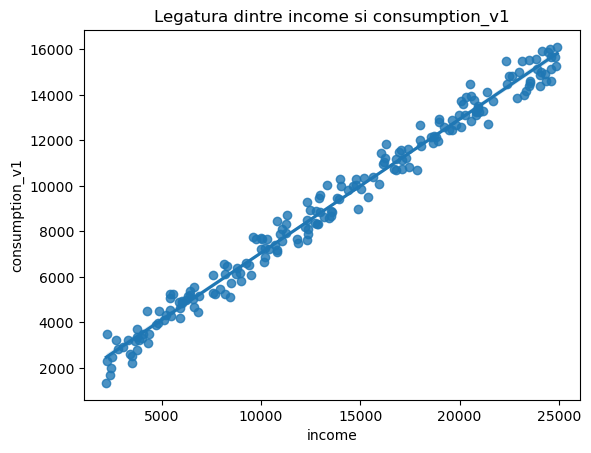

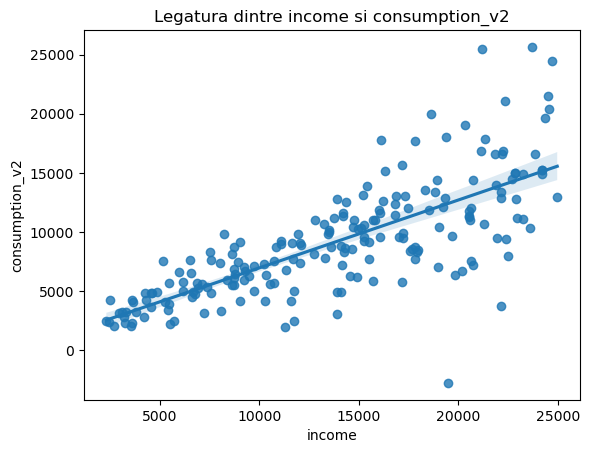

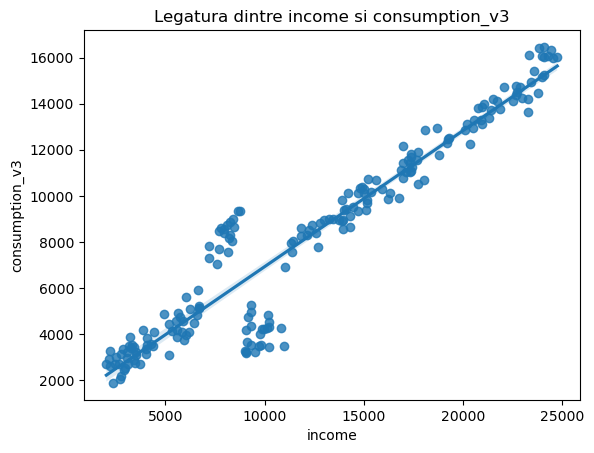

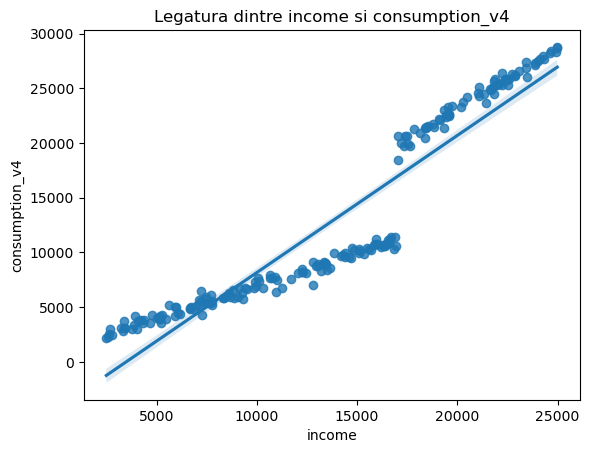

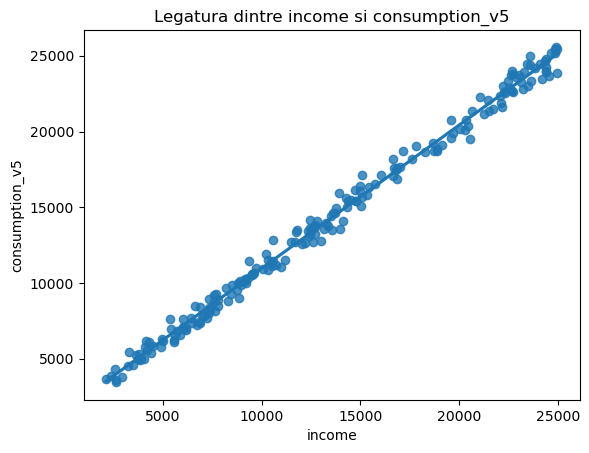

In [125]:
#liniaritate

for scenariu in scenarii_simulate_denumiri:
    relationship_plot = sns.regplot(data=df.sample(200), x='income',y=scenariu)
    relationship_plot.set_title(f"Legatura dintre income si {scenariu}")
    plt.show()


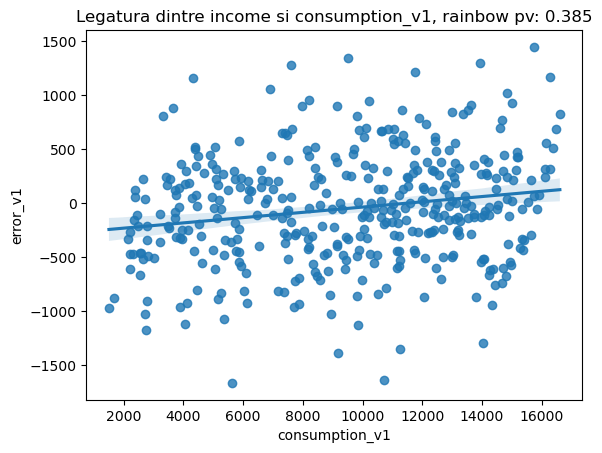

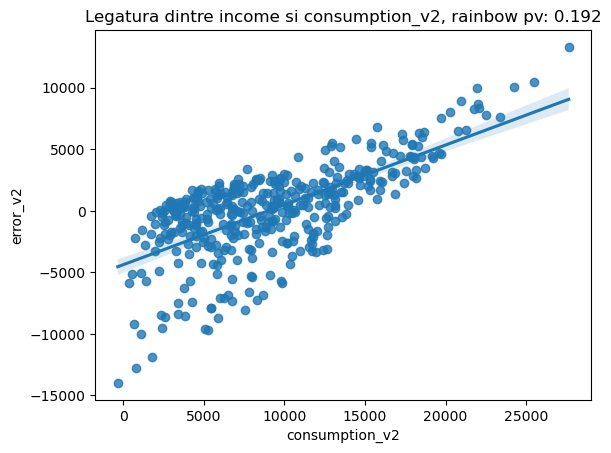

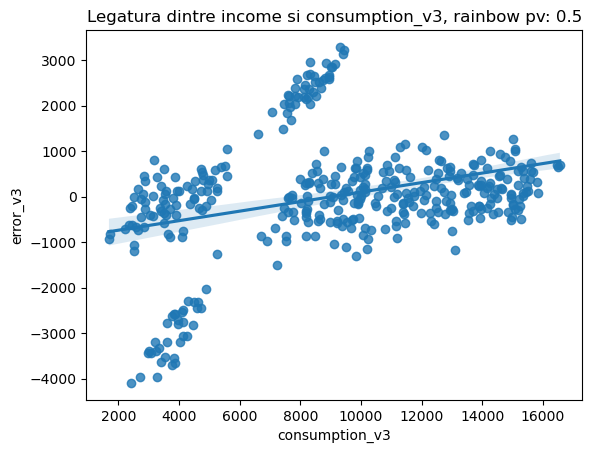

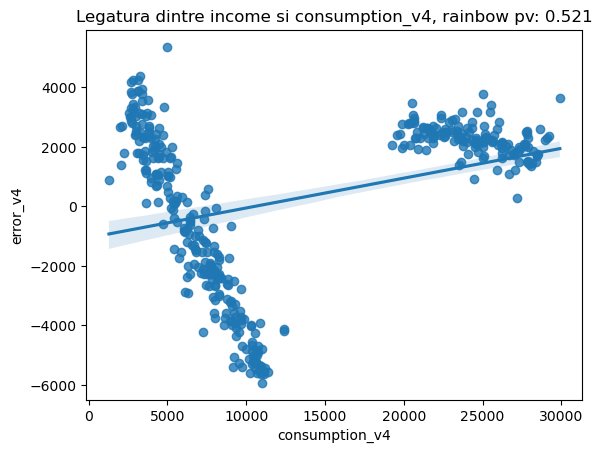

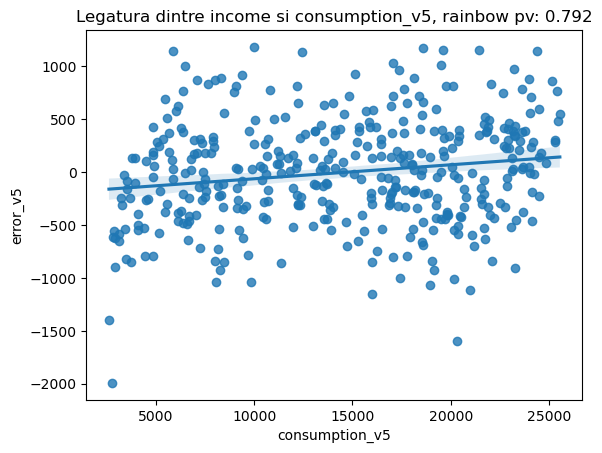

In [126]:
#liniaritate

for scenariu in scenarii_simulate_versiuni:
    relationship_plot = sns.regplot(data=df.sample(400), x=f"consumption_v{scenariu}",y=f"error_v{scenariu}")
    rainbow_statistic, rainbow_pv = linear_rainbow(eval(f"model_v{scenariu}"))
    title = f"Legatura dintre income si consumption_v{scenariu}, rainbow pv: {rainbow_pv.round(3)}"
    relationship_plot.set_title(title)
    plt.show()


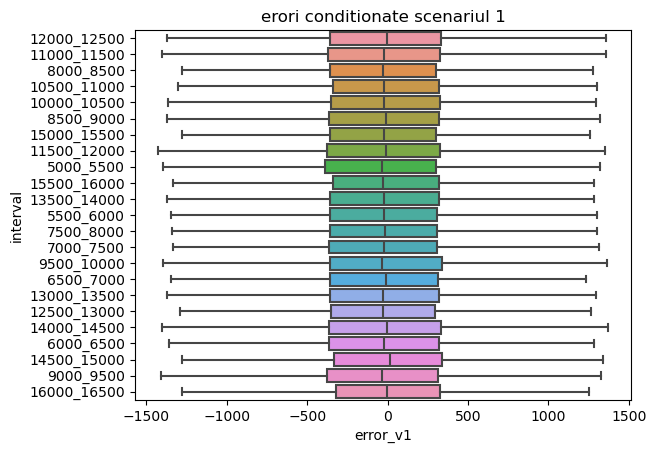

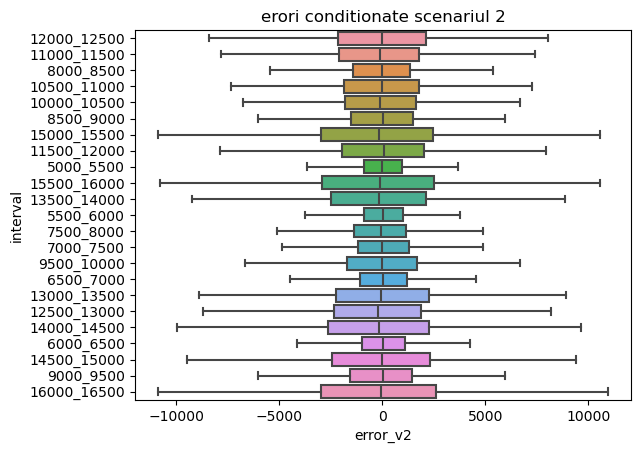

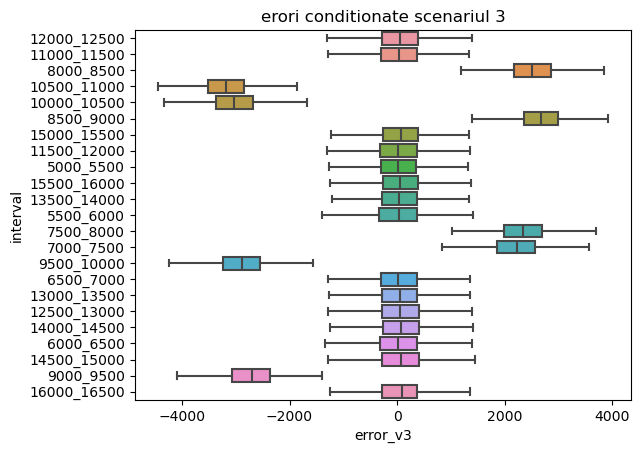

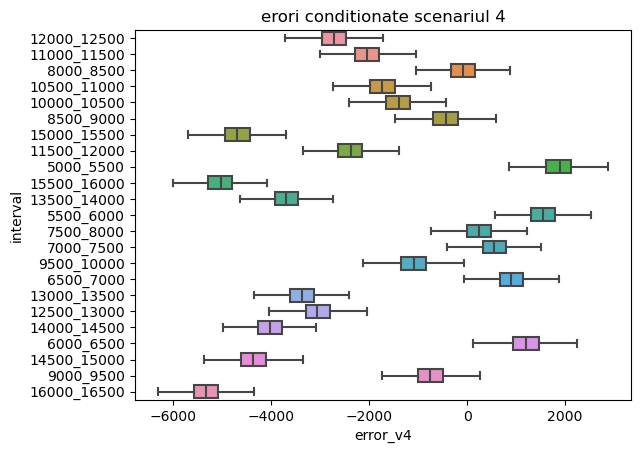

In [40]:
#Define the bins and labels
bins = range(2000, 30001, 500)
labels = [f"{i}_{i+500}" for i in range(2000, 30000, 500)]

# Add a new column with the interval labels
df['interval_income'] = pd.cut(df['income'], bins=bins, labels=labels, right=False)

for scenariu in scenarii_simulate_versiuni:
    #definim un doar un subset de intervale x pentru care sa vizualizam
    df_sample2 = df[df['income'].between(5000,16500)].copy() #pot fi schimbate 5000 si 6000 cu alte valori
    df_sample2['interval'] = df_sample2['interval_income'].astype('str')
    erori_conditionat_boxplot = sns.boxplot(data=df_sample2, y='interval',x=f"error_v{scenariu}", showfliers=False)
    erori_conditionat_boxplot.set_title(f"erori conditionate scenariul {scenariu}")
    plt.show()




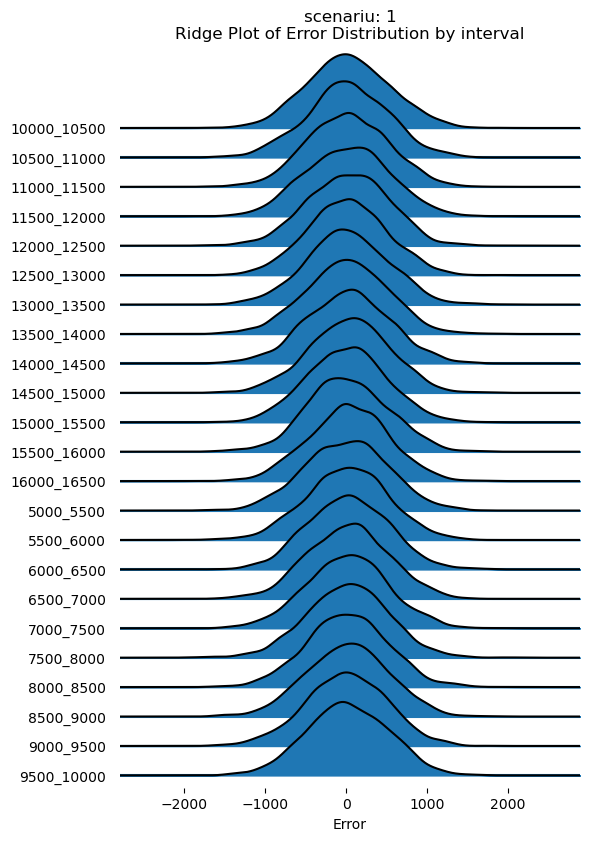

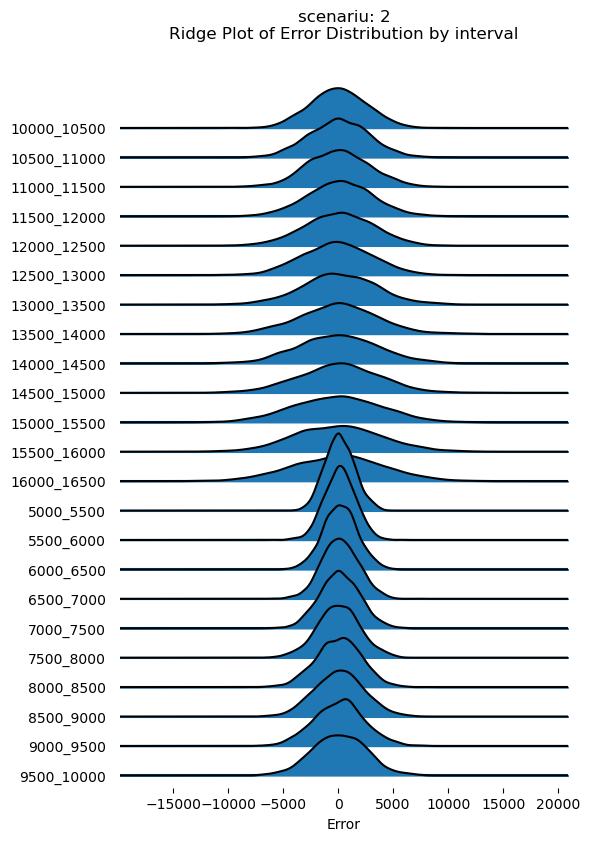

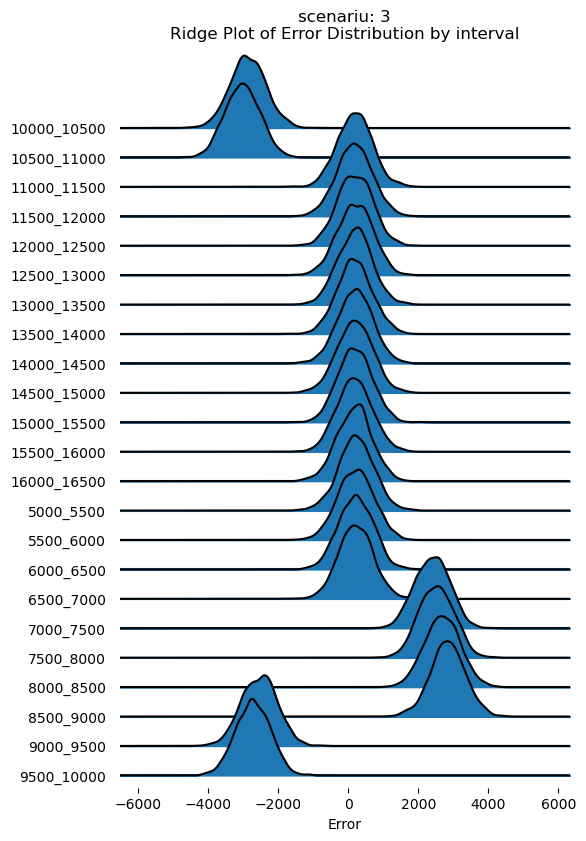

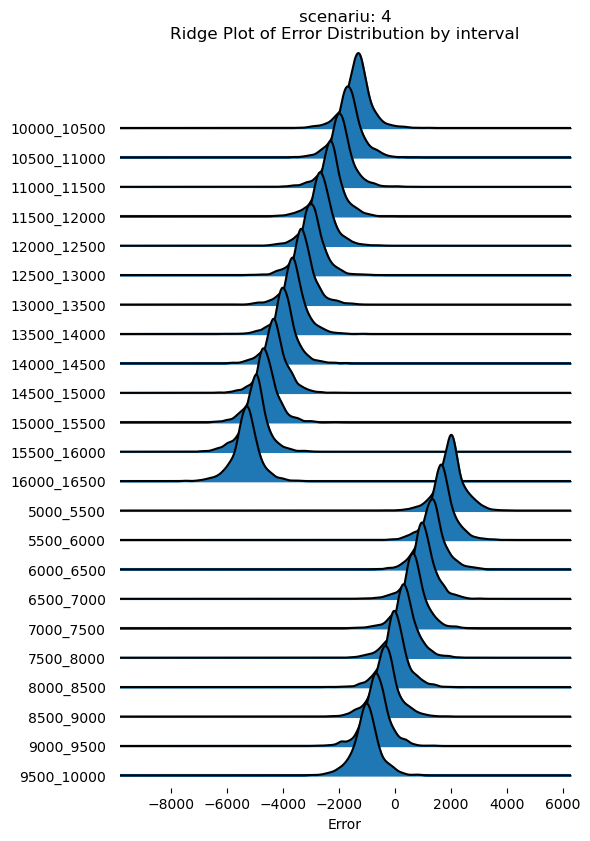

In [31]:
for scenariu in scenarii_simulate_versiuni:

    #Create a ridge plot using joypy
    fig, axes = joypy.joyplot(df_sample2, by="interval", column=f"error_v{scenariu}", figsize=(6, 8))

    # Customize the plot if needed
    plt.title(f"scenariu: {scenariu}\nRidge Plot of Error Distribution by interval")
    plt.xlabel("Error")
    plt.ylabel("Label")
    plt.show()

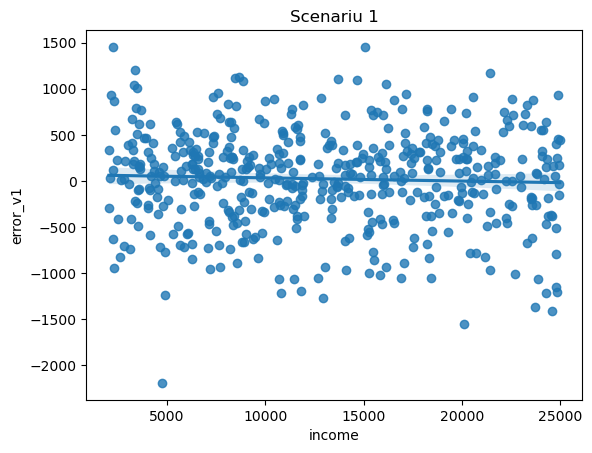

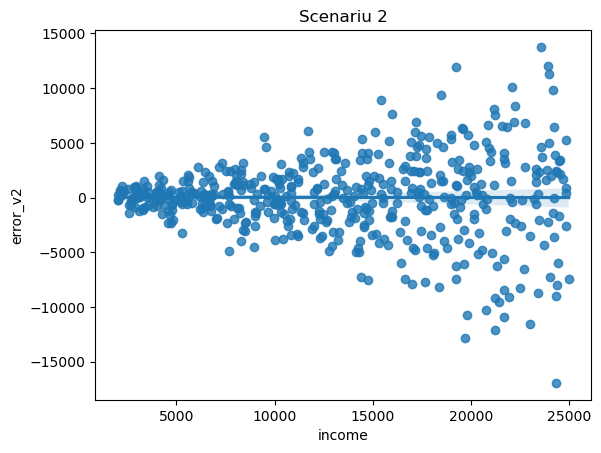

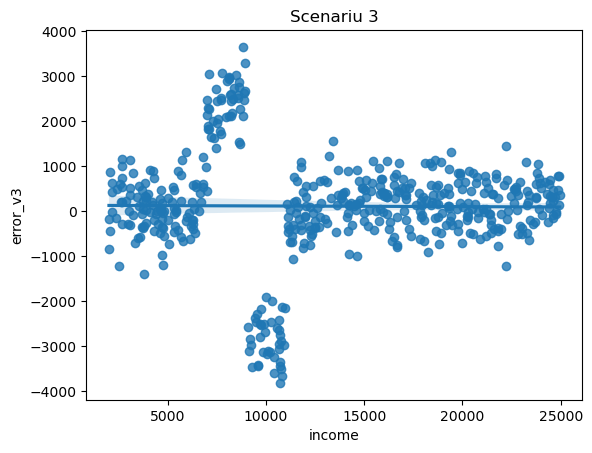

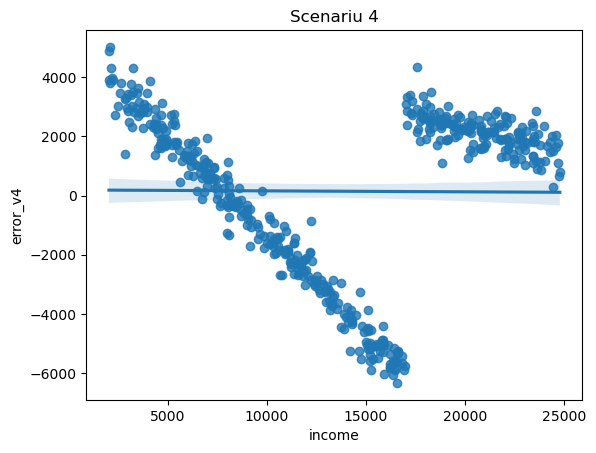

In [11]:
#variabile corelate cu erorile
for scenariu in scenarii_simulate_versiuni:
    scatter_plot_errors_x = relationship_plot = sns.regplot(data=df.sample(500), x='income',y=f'error_v{scenariu}')
    scatter_plot_errors_x.set_title(f'Scenariu {scenariu}')
    plt.show()